# Tema 5: Errores cuánticos

Curso ICC02.

Autor: Alejandro Mata Ali

##Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts
import numpy as np

---
# Corrección de bitflip

Vamos a empezar creando el circuito cuántico para corregir el bitflip de un qubit. Vamos a introducir un estado de entrada y si hay error o no (para hacer pruebas).

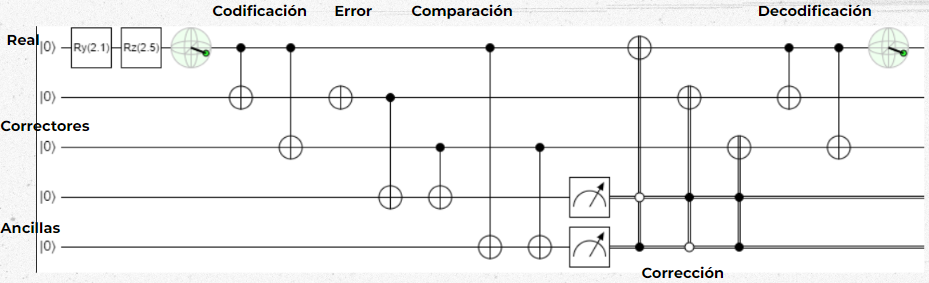

In [12]:
def bitflip(state: np.array, error:bool=True):
    #Registros
    qubit = QuantumRegister(1, 'q')
    qcomp = QuantumRegister(2, 'qc')
    anc   = QuantumRegister(2, 'anc')

    cr    = ClassicalRegister(2, 'c')

    qc    = QuantumCircuit(qubit, qcomp, anc, cr, name='Correction Bitflip')

    #Puertas
    #Estado
    qc.initialize(state, qubit[0])
    qc.barrier()
    #Codificación
    qc.cx([qubit[0],qubit[0]],qcomp[:])
    #Error
    if error:
        qc.x(qubit[0])
    #Comparación
    qc.cx(qcomp[:]+[qubit[0],qcomp[1]], [anc[0],anc[0],anc[1],anc[1]])
    qc.measure(anc[:],cr[:])

    #Corrección
    with qc.if_test((cr[0], 0)):
        with qc.if_test((cr[1], 1)):
            qc.x(qubit[0])
    with qc.if_test((cr[0], 1)):
        with qc.if_test((cr[1], 0)) as else_:
            qc.x(qcomp[0])
        with else_:
            qc.x(qcomp[1])

    #Decodificación
    qc.cx([qubit[0],qubit[0]],qcomp[:])

    return qc

Inicializamos el estado que queremos.

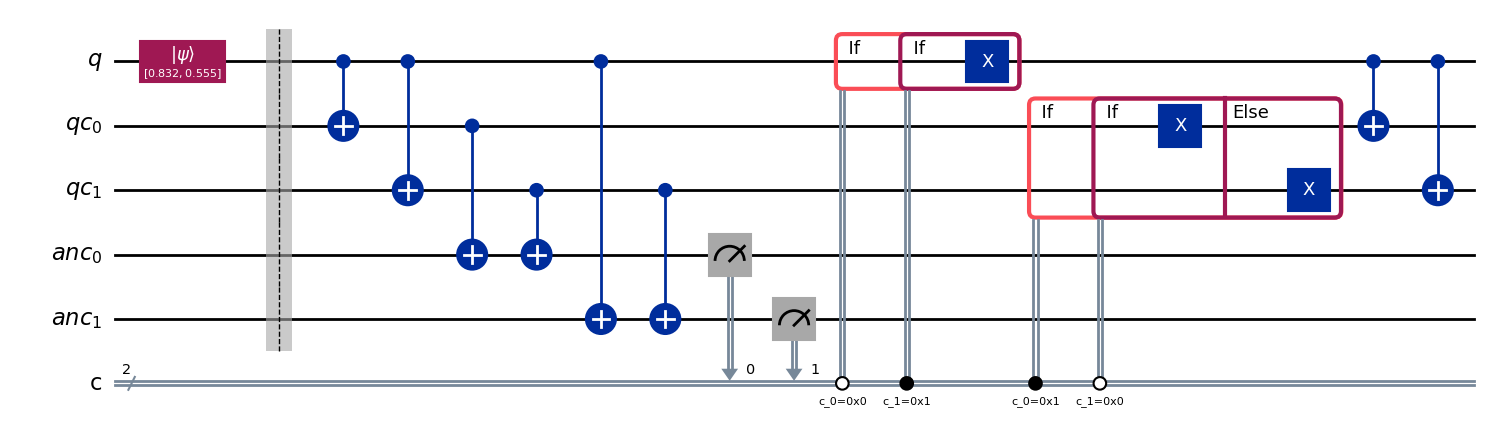

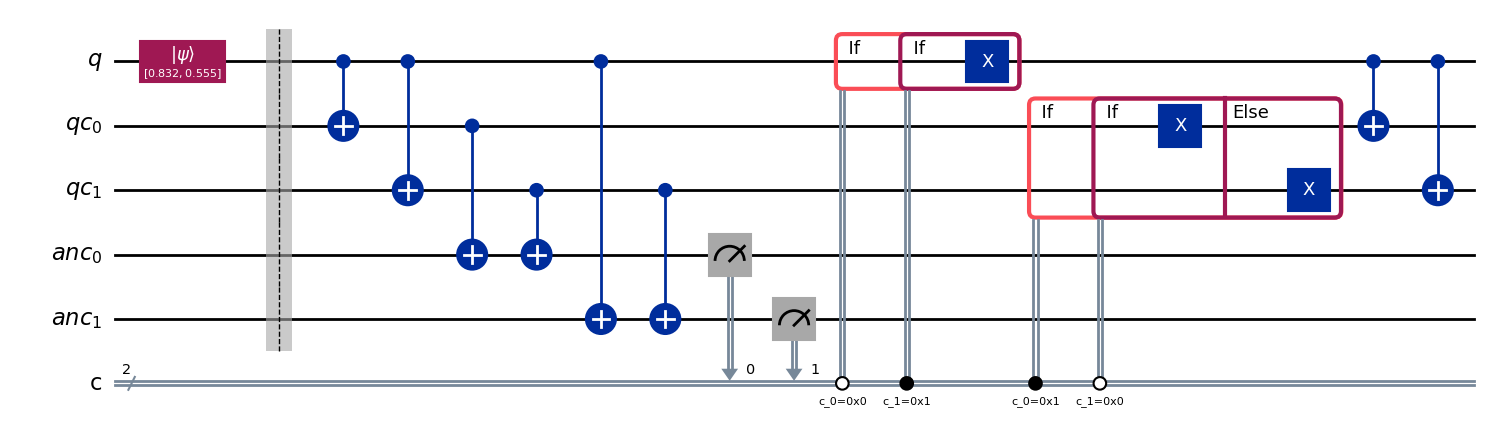

In [13]:
#Vector de estado
state = np.array([0.75, 0.5])
state /= np.sqrt(sum(state**2))
qc = bitflip(state, False)
qc.draw('mpl')

Añadimos la medición para comprobar.

In [14]:
crextra = ClassicalRegister(1, 's')
qc.add_register(crextra)
qc.measure(0,crextra[0])

Ejecutamos en simulador

In [ ]:
backend = GenericBackendV2(num_qubits=5)

qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
result = job.result()

# Indicamos cual es el registro de interes
indices = [0]

result_marginal = marginal_counts(result, indices=indices)
marginal_counts_value = result_marginal.get_counts()

plot_histogram(marginal_counts_value)

Nos da un error porque Qiskit.

Pasamos a Aer.

In [ ]:
#Para poder usar GPU
#!pip install qiskit-aer-gpu

In [15]:
from qiskit_aer import AerSimulator

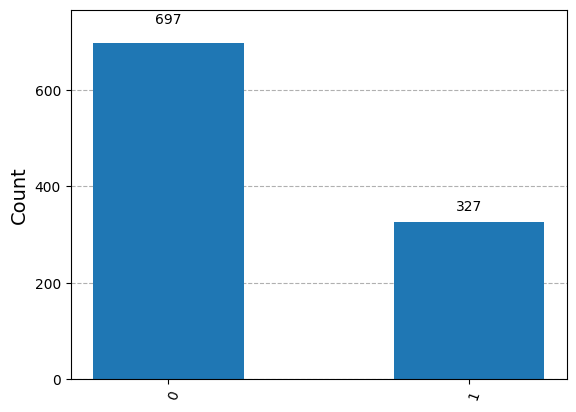

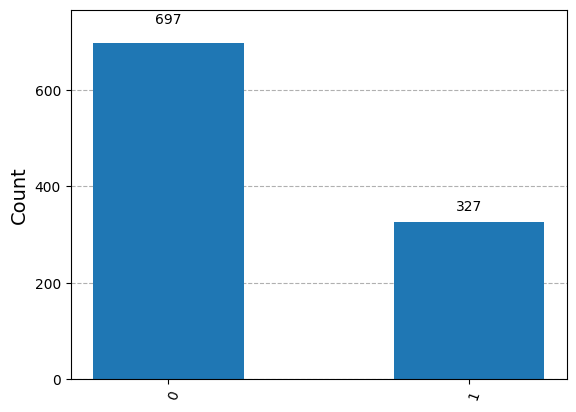

In [16]:
#Backend
backend = AerSimulator()
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
result = job.result()

# Indicamos cual es el registro de interes
indices = [2]

result_marginal = marginal_counts(result, indices=indices)
marginal_counts_value = result_marginal.get_counts()

plot_histogram(marginal_counts_value)

In [17]:
state**2

array([0.69230769, 0.30769231])

Vemos que funciona bien sin error.

Ahora probemos con error.

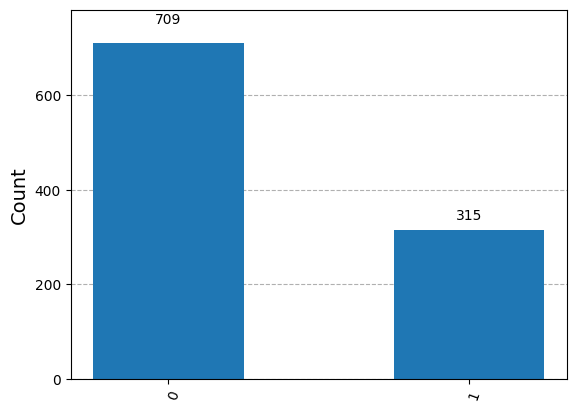

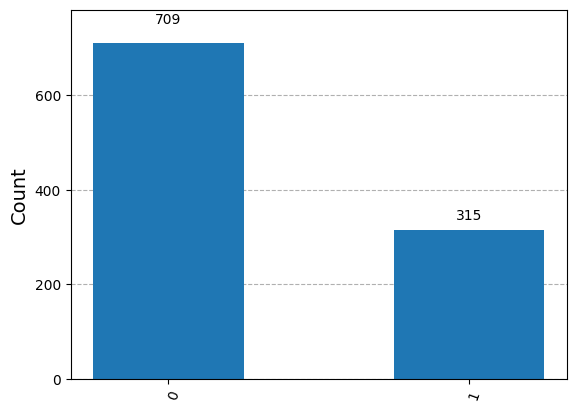

In [18]:
#Vector de estado
state = np.array([0.75, 0.5])
state /= np.sqrt(sum(state**2))
qc = bitflip(state, True)

crextra = ClassicalRegister(1, 's')
qc.add_register(crextra)
qc.measure(0,crextra[0])

#Backend
backend = AerSimulator()
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
result = job.result()

# Indicamos cual es el registro de interes
indices = [2]

result_marginal = marginal_counts(result, indices=indices)
marginal_counts_value = result_marginal.get_counts()

plot_histogram(marginal_counts_value)

Corrige bien con error.

---
# Corrección de fase

Vamos a implementar la corrección de fase.

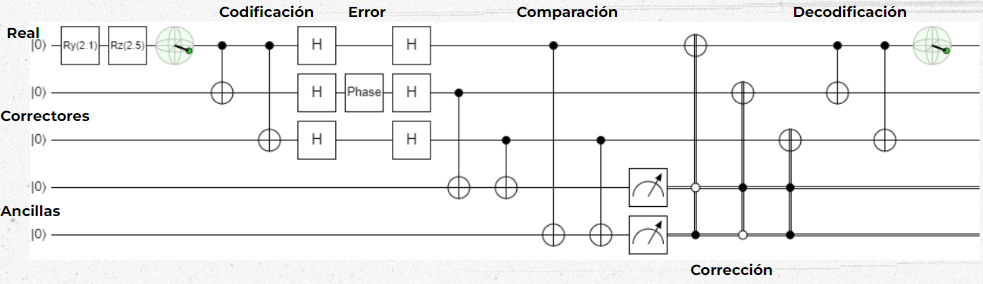

In [19]:
def phase(state: np.array, fase:float=0):
    #Registros
    qubit = QuantumRegister(1, 'q')
    qcomp = QuantumRegister(2, 'qc')
    anc   = QuantumRegister(2, 'anc')
    cr    = ClassicalRegister(2, 'c')
    qc    = QuantumCircuit(qubit, qcomp, anc, cr, name='Correction Bitflip')

    #Puertas
    #Estado
    qc.initialize(state, qubit[0])
    qc.barrier()
    #Codificación
    qc.cx([qubit[0],qubit[0]],qcomp[:])
    qc.h(qubit[:]+qcomp[:])
    #Error
    qc.p(fase,0)
    #Comparación
    qc.h(qubit[:]+qcomp[:])
    qc.cx(qcomp[:]+[qubit[0],qcomp[1]], [anc[0],anc[0],anc[1],anc[1]])
    qc.measure(anc[:],cr[:])

    #Corrección
    with qc.if_test((cr[0], 0)):
        with qc.if_test((cr[1], 1)):
            qc.x(qubit[0])
    with qc.if_test((cr[0], 1)):
        with qc.if_test((cr[1], 0)) as else_:
            qc.x(qcomp[0])
        with else_:
            qc.x(qcomp[1])

    #Decodificación
    qc.cx([qubit[0],qubit[0]],qcomp[:])

    return qc

Ejecutamos añadiendo una H para ver si corregimos bien.

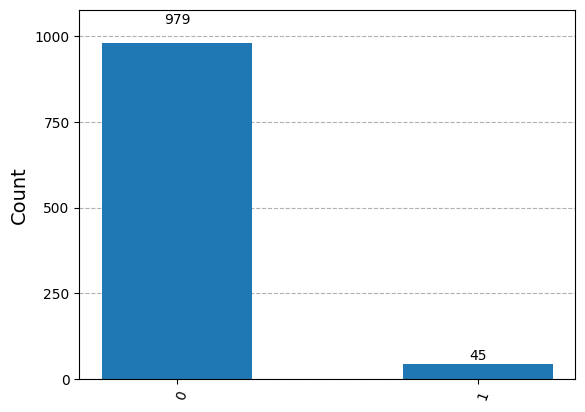

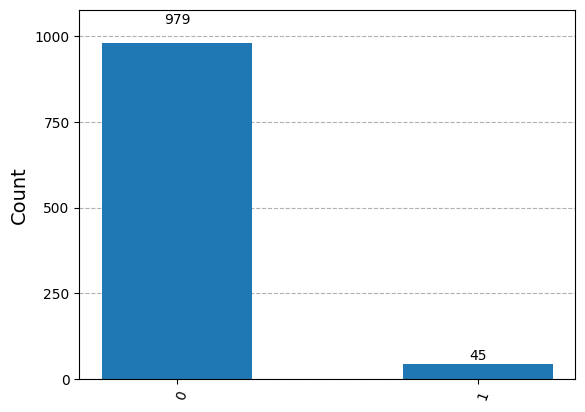

In [20]:
#Vector de estado
state = np.array([0.75, 0.5])
state /= np.sqrt(sum(state**2))
fase = 2

qc = phase(state, fase)

qc.h(0)

#Ponemos esto para comprobar
crextra = ClassicalRegister(1, 's')
qc.add_register(crextra)
qc.measure(0,crextra[0])

#Backend
backend = AerSimulator()
qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
result = job.result()

# Indicamos cual es el registro de interes
indices = [2]

result_marginal = marginal_counts(result, indices=indices)
marginal_counts_value = result_marginal.get_counts()

plot_histogram(marginal_counts_value)

Vamos a probar a hacerlo clásicamente.

In [21]:
H = np.array([[1,1],[1,-1]])/np.sqrt(2)

(H @ state)**2

array([0.96153846, 0.03846154])

Corrige bien.

---
# Modelo de errores

Podemos simular un modelo de errores, con un device con noise.

Obtenemos el servicio.

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService

Obtenemos el ordenador de IBM.

In [23]:
#Para una sola vez
service = QiskitRuntimeService(channel='ibm_quantum', #o ibm cloud en otros casos
                                token = '8f7a8e0bdf5f9ba503fc5bdec3bff688d26de8c2abffbb7acd7652a8301b1b4aeeb6c6be71fce6ef6df3b6329e332669b737d5a29fb22eced45b433fbf866b31')

#Si queremos guardarlo
QiskitRuntimeService.save_account(channel='ibm_quantum', #o ibm cloud en otros casos
                                token = '8f7a8e0bdf5f9ba503fc5bdec3bff688d26de8c2abffbb7acd7652a8301b1b4aeeb6c6be71fce6ef6df3b6329e332669b737d5a29fb22eced45b433fbf866b31',
                                overwrite=True)

In [24]:
#Escogemos el backend menos ocupado
backend_device = service.least_busy(operational=True, simulator=False, min_num_qubits=3)

Lo simulamos con sus características.

In [25]:
backend = AerSimulator.from_backend(backend_device)

Vamos a hacer un circuito del estado de Bell. Deberíamos obtener solo 00 + 11.

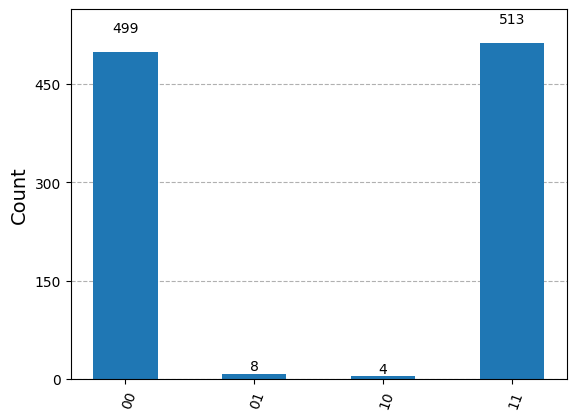

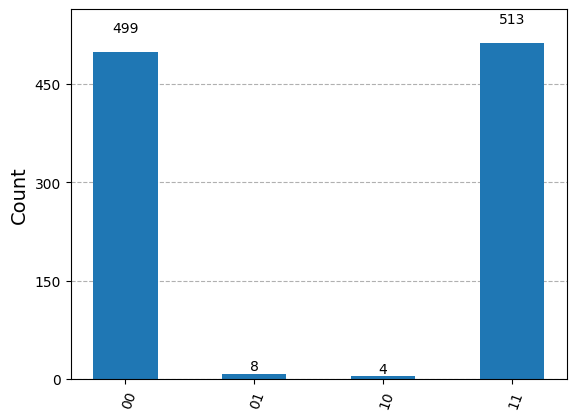

In [26]:
#Circuito
qc = QuantumCircuit(2,name='Circuit')

qc.h(0)
qc.cx(0,1)

qc.measure_all()

qc_transpiled = transpile(qc, backend)

#Creamos el job
job = backend.run(qc_transpiled)
result = job.result()

plot_histogram(result.get_counts())

Vemos que hay errores.

Cómo mitigarlos? Con el Sampler. https://docs.quantum.ibm.com/run/configure-error-mitigation#advanced-error

In [27]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, Options

In [28]:
sampler = Sampler(backend)
#Activamos las opciones
options = sampler.options

#Configuramos el tipo de correcciones que queremos
options.dynamical_decoupling.enable = True
options.twirling.enable_gates = True

Podemos probarlo en la nube.